In [1]:
try:
    from google.colab import drive
    import os

    drive.mount('/content/gdrive')
    os.chdir( '/content/gdrive/My Drive/Colab Notebooks/VAE/vae_cnn_tf' )
except:
    pass

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
tf.reset_default_graph()

Load Data

In [3]:
(xTrain,yTrain), (xTest,yTest) = mnist.load_data()
print( xTrain.shape, yTrain.shape, xTest.shape, yTest.shape )
imgSize = xTrain.shape[1]
# Add channel information
xTrain = np.reshape( xTrain, [-1,imgSize,imgSize,1] )
xTest = np.reshape( xTest, [-1,imgSize,imgSize,1] )
xTrain = xTrain.astype('float32') / 255.0
xTest = xTest.astype('float32') / 255.0
print( xTrain.shape, yTrain.shape, xTest.shape, yTest.shape )

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [4]:
inShape = (imgSize,imgSize,1)
batchSize = 128
kernelSize = 3
filters = 32
latentDim = 2
epochs = 30

Network model

In [ ]:
# tf.reset_default_graph()
with tf.variable_scope("Dataprovider"):
    inputs = tf.placeholder( dtype=tf.float32, shape=(None,imgSize,imgSize,1), name="input" )

with tf.variable_scope("encoder"):
    enc_conv_layer_1 = tf.layers.conv2d( inputs=inputs, filters=filters, 
                                         kernel_size=(3,3), strides=(2,2), 
                                         padding="same", activation=tf.nn.relu,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name="enc_conv_layer_1" )
    enc_conv_layer_2 = tf.layers.conv2d( inputs=enc_conv_layer_1, filters=2*filters,
                                         kernel_size=(3,3), strides=(2,2),
                                         padding="same", activation=tf.nn.relu,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name="enc_conv_layer_2" )
    enc_flat_out = tf.contrib.layers.flatten( enc_conv_layer_2 )
    enc_dense_1 = tf.layers.dense( inputs=enc_flat_out, units=16, activation=tf.nn.relu,
                                   kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                   name="enc_dense_1" )
    z_mean = tf.layers.dense( inputs=enc_dense_1, units=latentDim, activation=None,
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              name="z_mean" )
    z_logvar = tf.layers.dense( inputs=enc_dense_1, units=latentDim, activation=None,
                                kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="z_logvar" )

with tf.variable_scope("sampling"):
    eps = tf.random.normal( tf.shape(z_mean), mean=0.0, stddev=1.0, name="eps" )
    z = tf.add( z_mean, tf.exp(0.5*z_logvar)*eps, name = "z" )
    
with tf.variable_scope("decoder"):
    dec_dense_1 = tf.layers.dense( inputs=z, units=np.prod(enc_conv_layer_2.get_shape()[1:]), activation=tf.nn.relu,
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True),
                                  name="dec_dense_1" )
    recon_shape = enc_conv_layer_2.get_shape().as_list()
    recon_shape[0] = -1
    dec_reshape_out = tf.reshape( dec_dense_1, recon_shape )
    dec_deconv_1 = tf.layers.conv2d_transpose( inputs=dec_reshape_out, filters=2*filters,
                                               kernel_size=(3,3), strides=(2,2),
                                               padding="same", activation=tf.nn.relu,
                                               kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                               name="dec_deconv_1" )
    dec_deconv_2 = tf.layers.conv2d_transpose( inputs=dec_deconv_1, filters=filters,
                                               kernel_size=(3,3), strides=(2,2),
                                               padding="same", activation=tf.nn.relu,
                                               kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                               name="dec_deconv_2" )
    dec_out = tf.layers.conv2d_transpose( inputs=dec_deconv_2, filters=1,
                                          kernel_size=(3,3), strides=(1,1),
                                          padding="same", activation=tf.nn.sigmoid,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          name="dec_out" )

Print model details

In [ ]:
nodes = ( inputs, enc_conv_layer_1, enc_conv_layer_2, enc_flat_out, 
          enc_dense_1, z_mean, z_logvar, 
          z,
          dec_dense_1, dec_reshape_out, 
          dec_deconv_1, dec_deconv_2, dec_out )
for n in nodes:
    print( "{:33s}    {}".format(n.name,n.get_shape()) )

Dataprovider/input:0                 (?, 28, 28, 1)
encoder/enc_conv_layer_1/Relu:0      (?, 14, 14, 32)
encoder/enc_conv_layer_2/Relu:0      (?, 7, 7, 64)
encoder/Flatten/flatten/Reshape:0    (?, 3136)
encoder/enc_dense_1/Relu:0           (?, 16)
encoder/z_mean/BiasAdd:0             (?, 2)
encoder/z_logvar/BiasAdd:0           (?, 2)
sampling/z:0                         (?, 2)
decoder/dec_dense_1/Relu:0           (?, 3136)
decoder/Reshape:0                    (?, 7, 7, 64)
decoder/dec_deconv_1/Relu:0          (?, 14, 14, 64)
decoder/dec_deconv_2/Relu:0          (?, 28, 28, 32)
decoder/dec_out/Sigmoid:0            (?, 28, 28, 1)


Loss definitions

In [ ]:
with tf.variable_scope("cost"):
    likelihood = tf.reduce_mean( tf.reduce_sum(inputs*tf.log(dec_out+1e-12)+
                                               (1.0-inputs)*tf.log(1.0-dec_out+1e-12),axis=[1,2,3]), 
                                name="loss_recon" )
    kl_div = tf.reduce_mean( 0.50*tf.reduce_sum(tf.exp(z_logvar)+tf.square(z_mean)-1.0-z_logvar,axis=1), 
                          name="kl_div" )
    cost = tf.add( -likelihood, kl_div, name="cost" )
    
with tf.variable_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer( learning_rate = 0.01, beta1 = 0.99, beta2 = 0.999 )
#     optimizer = tf.train.RMSPropOptimizer( 0.05 )
#     optimizer = tf.train.GradientDescentOptimizer( 0.01 )
    objective = optimizer.minimize(cost)

In [ ]:
def plot_results( sess, testX, testY, epochCount = 0 ):
  
  zMean, zLogVar = sess.run( [z_mean,z_logvar], feed_dict={inputs:testX} )
  
  maxMean = 1.1*np.max( [ 4.0, np.abs(np.max(zMean)), np.abs(np.min(zMean)) ] )
  maxLogVar = 1.1*np.max( [ 4.0, np.abs(np.max(zLogVar)), np.abs(np.min(zLogVar)) ] )
  
  fig, (ax1,ax2,ax3) = plt.subplots( 1, 3, figsize = (20,6) )
  filename = "{:04d}.png".format(epochCount)
  ax0 = fig.add_axes([0.05, 0.10, 0.02, 0.75])
  
  axx = ax1.scatter( zMean[:,0], zMean[:,1], c = testY )
  ax1.set_xlim( [-maxMean, +maxMean] ); ax1.set_ylim( [-maxMean, +maxMean] );
  fig.colorbar( axx, cax = ax0 )
  ax1.set_xlabel( "z0" )
  ax1.set_ylabel( "z1" )
  ax1.set_title( "Mean of latent variable" )
  
  ax2.scatter( zLogVar[:,0], zLogVar[:,1], c=testY )
  ax2.set_xlim( [-maxLogVar, +maxLogVar] ); ax2.set_ylim( [-maxLogVar, +maxLogVar] );
  ax2.set_xlabel( "z0" )
  ax2.set_ylabel( "z1" )
  ax2.set_title( "Log Var of latent variable" )
  
  n = 30
  digitSize = 28
  figure = np.zeros( (n*digitSize,n*digitSize) )
  gridX = np.linspace( -4, 4, n )
  gridY = np.linspace( -4, 4, n )[::-1]
  
  
  for i,yi in enumerate(gridY):
    for j,xi in enumerate(gridX):
      zSample = np.array( [[xi,yi]] )
      xDecoded = sess.run( dec_out, feed_dict={z:zSample} )
      digit = xDecoded[0].reshape( digitSize, digitSize )
      figure[i*digitSize:(i+1)*digitSize,j*digitSize:(j+1)*digitSize] = digit
      
  startRange = digitSize // 2
  endRange = n*digitSize + startRange + 1
  pixelRange = np.arange( startRange, endRange, digitSize )
  sampleRangeX = np.round( gridX, 1 )
  sampleRangeY = np.round( gridY, 1 )
  ax3.set_xlabel( "z0" )
  ax3.set_ylabel( "z1" )
  ax3.imshow( figure, cmap = 'Greys_r' )
  plt.setp( ax3, xticks = np.linspace(0,840,2), yticks = np.linspace(0,840,2), xticklabels = np.linspace(-4.0,+4.0,2), yticklabels = np.linspace(-4.0,+4.0,2) )
  
  plt.title( "Epoch = {}".format(epochCount) )
#   plt.savefig( filename )
  plt.show()

Training

-542.9584 0.002550834 542.96094


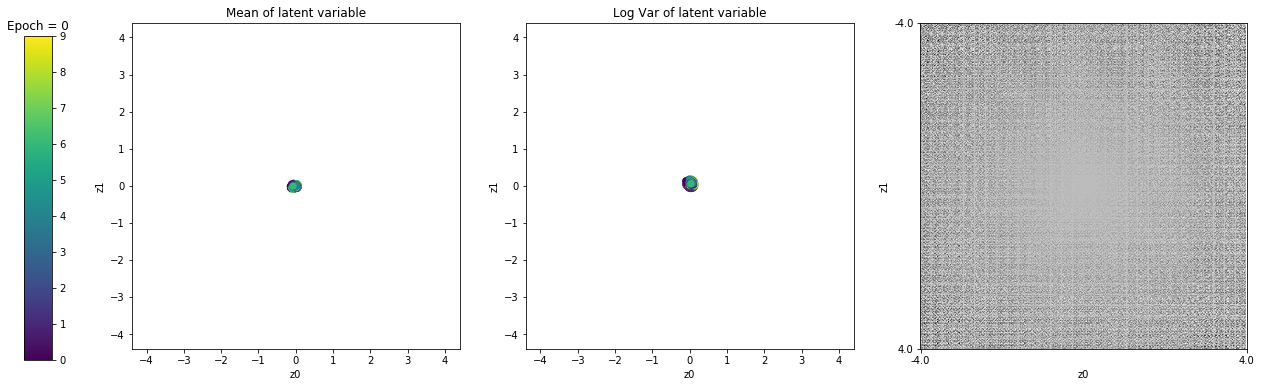

0 -207.65504 0.048611693 207.70366


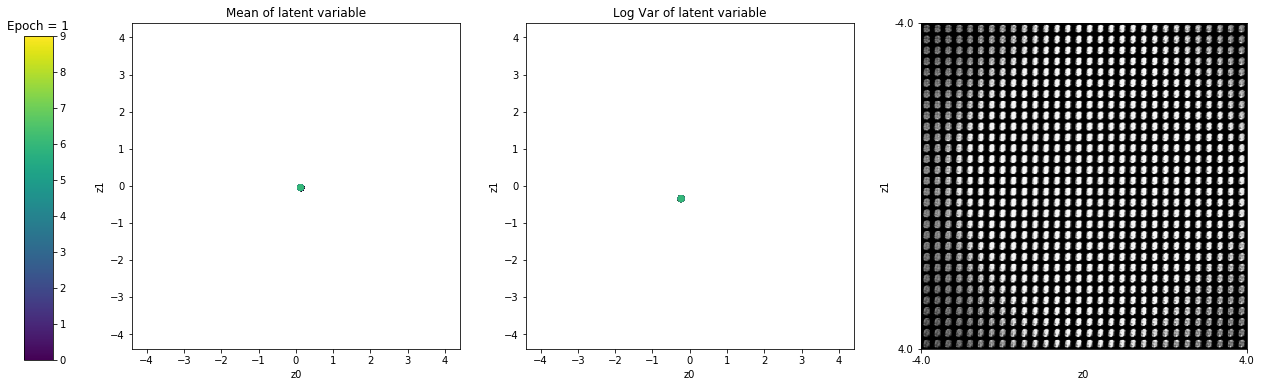

In [ ]:
evo_ll = []
evo_kl = []
evo_cc = []
with tf.Session() as sess:
    sess.run( tf.global_variables_initializer() )
    # Evaluate loss terms for 
    ll, kl, cc = sess.run( [likelihood,kl_div,cost], feed_dict={inputs:xTest} )
    print( ll, kl, cc )
    evo_ll.append(ll)
    evo_kl.append(kl)
    evo_cc.append(cc)
    plot_results( sess, xTest, yTest )
    for ep in range(epochs):
        dsStartPos = 0
        dsEndPos = dsStartPos + batchSize
        while dsEndPos < xTrain.shape[0]:
#             print( dsStartPos, dsEndPos )
            sess.run( objective, feed_dict={inputs:xTrain[dsStartPos:dsEndPos,:]})
            dsStartPos, dsEndPos = dsEndPos, dsEndPos+batchSize
        # Evaluate loss terms for 
        ll, kl, cc = sess.run( [likelihood,kl_div,cost], feed_dict={inputs:xTest} )
        print( ep, ll, kl, cc )
        evo_ll.append(ll)
        evo_kl.append(kl)
        evo_cc.append(cc)
        plot_results( sess, xTest, yTest, ep+1 )
#         plot_results( sess, xTrain[0:1000,:], yTest[:1000], ep+1 )

In [ ]:
fig_ll = plt.figure()
plt.plot( evo_ll )

fig_kl = plt.figure()
plt.plot( evo_kl )

fig_cc = plt.figure()
plt.plot( evo_cc )